# Creating NBA Shot Charts with Python

## Dependencies

In [154]:
from nba_api.stats.endpoints import shotchartdetail, playercareerstats
from nba_api.stats.static import players, teams
from modules.datasets import Datasets
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data
### Finding IDs of PLayer and Team to get the Data

In [155]:
# get player id
name = "Isaiah Thomas"
id = Datasets.get_json_from_name(name)['id']
print(f'{name} id: {id}')

Isaiah Thomas id: 202738


In [156]:
career = Datasets.get_player_career(id)
team_id = career[career.TEAM_ABBREVIATION == 'BOS'].TEAM_ID.values[0]
print(f'{name} team id: {team_id}')

Isaiah Thomas team id: 1610612738


### Get Data

In [157]:
season = '2015-16'
shot_json = shotchartdetail.ShotChartDetail(
    team_id=team_id,
    player_id=id,
    season_nullable=season,
    context_measure_simple='FGA'
)

In [158]:
shot_data = shot_json.get_data_frames()[0]
shot_data.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021500005,64,202738,Isaiah Thomas,1610612738,Boston Celtics,1,5,30,...,Center(C),24+ ft.,24,-61,237,1,0,20151028,BOS,PHI
1,Shot Chart Detail,0021500005,81,202738,Isaiah Thomas,1610612738,Boston Celtics,1,3,30,...,Center(C),Less Than 8 ft.,6,56,41,1,0,20151028,BOS,PHI
2,Shot Chart Detail,0021500005,114,202738,Isaiah Thomas,1610612738,Boston Celtics,1,0,52,...,Right Side Center(RC),24+ ft.,26,123,232,1,0,20151028,BOS,PHI
3,Shot Chart Detail,0021500005,119,202738,Isaiah Thomas,1610612738,Boston Celtics,1,0,11,...,Center(C),Less Than 8 ft.,1,-14,-10,1,0,20151028,BOS,PHI
4,Shot Chart Detail,0021500005,146,202738,Isaiah Thomas,1610612738,Boston Celtics,2,9,37,...,Center(C),Less Than 8 ft.,2,-20,13,1,0,20151028,BOS,PHI


### Data Analysis

In [159]:
shot_data.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [160]:
shot_data.SHOT_MADE_FLAG.value_counts(normalize=True).head()

0    0.572359
1    0.427641
Name: SHOT_MADE_FLAG, dtype: float64

In [161]:
shot_data.SHOT_ZONE_BASIC.value_counts(normalize=True)

Restricted Area          0.366136
Above the Break 3        0.287265
Mid-Range                0.150507
In The Paint (Non-RA)    0.146889
Left Corner 3            0.026773
Right Corner 3           0.022431
Name: SHOT_ZONE_BASIC, dtype: float64

In [162]:
print("Tipos de arremesso mais comuns:")
shot_data.ACTION_TYPE.value_counts(normalize=True).head(10)

Tipos de arremesso mais comuns:


Jump Shot                         0.387120
Driving Layup Shot                0.138929
Pullup Jump shot                  0.093343
Layup Shot                        0.073082
Driving Finger Roll Layup Shot    0.049204
Running Layup Shot                0.045586
Floating Jump shot                0.045586
Step Back Jump shot               0.033285
Driving Floating Jump Shot        0.027496
Driving Reverse Layup Shot        0.020984
Name: ACTION_TYPE, dtype: float64

## Create Shot Chart

### Create Court

In [163]:
def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    ax.plot([-250, 250], [0, 0], linewidth=4, color='white')
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    return ax

### Calculate Percentages by Court Zone

In [164]:
# Chart common parameters
gridsize = 25
cmap = "inferno"
extent=(-250, 250, 422.5, -47.5)

In [165]:
# create frequency of shots per hexbin zone
shots_hex = plt.hexbin(
    shot_data.LOC_X, shot_data.LOC_Y + 60,
    extent=extent, cmap=cmap, gridsize=gridsize)
plt.close()
shots_hex_array = shots_hex.get_array()
freq_by_hex = shots_hex_array / sum(shots_hex_array)

In [166]:
# create field goal % per hexbin zone
makes_df = shot_data[shot_data.SHOT_MADE_FLAG == 1] # filter dataframe for made shots
makes_hex = plt.hexbin(makes_df.LOC_X, makes_df.LOC_Y + 60, cmap=cmap,
                gridsize=gridsize, extent=extent) # create hexbins
plt.close()
pcts_by_hex = makes_hex.get_array() / shots_hex.get_array()
pcts_by_hex[np.isnan(pcts_by_hex)] = 0  # convert NAN values to 0

In [167]:
# filter data for zone with at least 5 shots made
sample_sizes = shots_hex.get_array()
filter_threshold = 5
for i in range(len(pcts_by_hex)):
    if sample_sizes[i] < filter_threshold:
        pcts_by_hex[i] = 0
x = [i[0] for i in shots_hex.get_offsets()]
y = [i[1] for i in shots_hex.get_offsets()]
z = pcts_by_hex

In [168]:
z2 = freq_by_hex 

## Shotchart

In [169]:
sizes = freq_by_hex * 1000

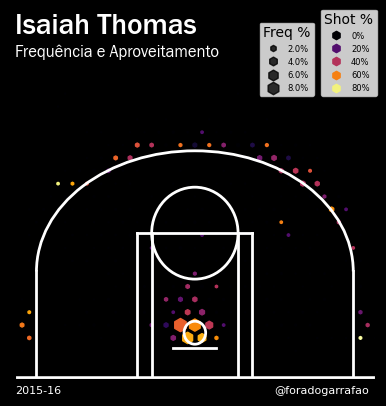

In [170]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

# Plot hexbins
scatter = ax.scatter(x, y, c=z, cmap=cmap, marker='h', s=sizes)

# Draw court
ax = create_court(ax, 'white')

# Add legends
max_freq = max(freq_by_hex)
max_size = max(sizes)
legend_acc = plt.legend(
    *scatter.legend_elements(num=5, fmt="{x:.0f}%",
                             func=lambda x: x * 100),
    loc=[0.85,0.785], title='Shot %', fontsize=6)
legend_freq = plt.legend(
    *scatter.legend_elements(
        'sizes', num=5, alpha=0.8, fmt="{x:.1f}%"
        , func=lambda s: s / max_size * max_freq * 100
    ),
    loc=[0.68,0.785], title='Freq %', fontsize=6)
plt.gca().add_artist(legend_acc)

# Add title
plt.text(-250, 450, f"{name}", fontsize=21, color='white',
         fontname='Franklin Gothic Medium')
plt.text(-250, 420, "Frequência e Aproveitamento", fontsize=12, color='white',
         fontname='Franklin Gothic Book')
plt.text(-250, -20, season, fontsize=8, color='white')
plt.text(110, -20, '@foradogarrafao', fontsize=8, color='white')

plt.show()

## Volume of Shots Chart

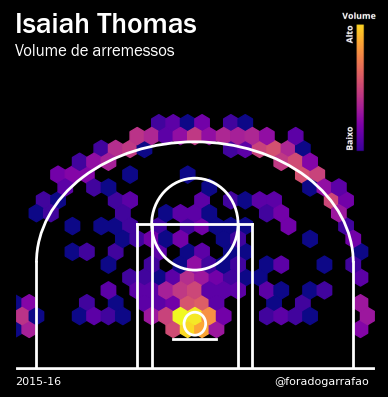

In [171]:
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

# Plot hexbin of shots
hexbin = ax.hexbin(shot_data.LOC_X, shot_data.LOC_Y + 60, cmap='plasma',
          bins="log", gridsize=25, mincnt=2, extent=(-250, 250, 422.5, -47.5))

# Draw court
ax = create_court(ax, 'white')

# Annotate player name and season
plt.text(-250, 440, f"{name}", fontsize=21, color='white',
         fontname='Franklin Gothic Medium')
plt.text(-250, 410, "Volume de arremessos", fontsize=12, color='white',
         fontname='Franklin Gothic Book')
plt.text(-250, -20, season, fontsize=8, color='white')
plt.text(110, -20, '@foradogarrafao', fontsize=8, color='white')

# add colorbar
im = plt.imread("../imagens/Colorbar Shotcharts.png")
newax = fig.add_axes([0.56, 0.6, 0.45, 0.4], anchor='NE', zorder=1)
newax.xaxis.set_visible(False)
newax.yaxis.set_visible(False)
newax.imshow(im)

# Save and show figure
# plt.savefig('ShotChart.png', dpi=300, bbox_inches='tight')
plt.show()

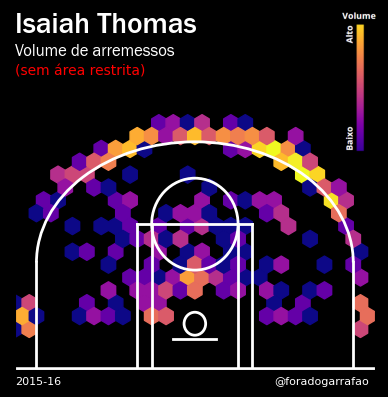

In [208]:
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

# Plot hexbin of shots
cond = ~((-45 < shot_data.LOC_X) & (shot_data.LOC_X < 45) & (-40 < shot_data.LOC_Y) & (shot_data.LOC_Y < 45))
x = shot_data.LOC_X[cond]
y = shot_data.LOC_Y[cond] + 60
hexbin = ax.hexbin(x, y, cmap='plasma',
          bins="log", gridsize=25, mincnt=2, extent=(-250, 250, 422.5, -47.5))

# Draw court
ax = create_court(ax, 'white')

# Annotate player name and season
plt.text(-250, 440, f"{name}", fontsize=21, color='white',
         fontname='Franklin Gothic Medium')
plt.text(-250, 410, "Volume de arremessos", fontsize=12, color='white',
         fontname='Franklin Gothic Book')
plt.text(-250, 385, "(sem área restrita)", fontsize=10, color='red')
plt.text(-250, -20, season, fontsize=8, color='white')
plt.text(110, -20, '@foradogarrafao', fontsize=8, color='white')

# add colorbar
im = plt.imread("../imagens/Colorbar Shotcharts.png")
newax = fig.add_axes([0.56, 0.6, 0.45, 0.4], anchor='NE', zorder=1)
newax.xaxis.set_visible(False)
newax.yaxis.set_visible(False)
newax.imshow(im)

# Save and show figure
# plt.savefig('ShotChart.png', dpi=300, bbox_inches='tight')
plt.show()

## Makes and Misses Chart

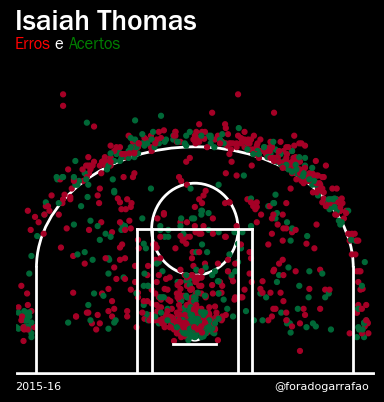

In [209]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

plt.text(-250, 450, f"{name}", fontsize=21, color='white',
         fontname='Franklin Gothic Medium')
plt.text(-250, 425, "Erros", fontsize=12, color='red',
         fontname='Franklin Gothic Book')
plt.text(-195, 425, "e", fontsize=12, color='white',
         fontname='Franklin Gothic Book')
plt.text(-175, 425, "Acertos", fontsize=12, color='green',
         fontname='Franklin Gothic Book')
plt.text(-250, -20, season, fontsize=8, color='white')
plt.text(110, -20, '@foradogarrafao', fontsize=8, color='white')

ax = create_court(ax, 'white')
sc = ax.scatter(shot_data.LOC_X, shot_data.LOC_Y + 60, c=shot_data.SHOT_MADE_FLAG, cmap='RdYlGn', s=12)

plt.show()